In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
sp = pd.read_csv('../data/sp1950.csv')
sp = sp[['Date', 'Open', 'Close', 'Adj Close']]
sp = sp.rename(columns={'Adj Close': 'Value'})
sp.head()

,Date,Open,Close,Value
0,1/3/50,16.66,16.66,16.66
1,1/4/50,16.85,16.85,16.85
2,1/5/50,16.93,16.93,16.93
3,1/6/50,16.98,16.98,16.98
4,1/9/50,17.08,17.08,17.08


In [3]:
sp.tail()

,Date,Open,Close,Value
17528,8/30/19,2861.280029,2926.46,2926.46
17529,9/3/19,2861.280029,2906.27,2906.27
17530,9/4/19,2861.280029,2937.78,2937.78
17531,9/5/19,2861.280029,2976.00,2976.00
17532,9/6/19,2861.280029,2978.71,2978.71


In [4]:
def date2datetime(date):
    month, day, year = date.split('/')
    if int(year) > 20:
        year = int(year) + 1900
    else:
        year = int(year) + 2000
    try:
        return pd.to_datetime(f'{year}-{month}-{day}')
    except:
        print(date)

In [5]:
date2datetime('1/3/50')

Timestamp('1950-01-03 00:00:00')

In [6]:
sp.Date = sp.Date.apply(date2datetime)
sp.head()

,Date,Open,Close,Value
0,1950-01-03,16.66,16.66,16.66
1,1950-01-04,16.85,16.85,16.85
2,1950-01-05,16.93,16.93,16.93
3,1950-01-06,16.98,16.98,16.98
4,1950-01-09,17.08,17.08,17.08


In [7]:
sp['ChangeSinceOpen'] = sp['Close'] / sp['Open']
sp.tail()

,Date,Open,Close,Value,ChangeSinceOpen
17528,2019-08-30,2861.280029,2926.46,2926.46,1.022780
17529,2019-09-03,2861.280029,2906.27,2906.27,1.015724
17530,2019-09-04,2861.280029,2937.78,2937.78,1.026736
17531,2019-09-05,2861.280029,2976.00,2976.00,1.040094
17532,2019-09-06,2861.280029,2978.71,2978.71,1.041041


In [8]:
sp['DailyChange'] = np.nan
sp['OvernightChange'] = np.nan
for day in range(1, sp.shape[0]):
    sp.loc[day, 'DailyChange'] = (sp.loc[day, 'Value'] 
                                  / sp.loc[day - 1, 'Value'])
    sp.loc[day, 'OvernightChange'] = (sp.loc[day, 'Open'] 
                                      / sp.loc[day - 1, 'Close'])
sp.tail()        

,Date,Open,Close,Value,ChangeSinceOpen,DailyChange,OvernightChange
17528,2019-08-30,2861.280029,2926.46,2926.46,1.022780,1.000643,0.978356
17529,2019-09-03,2861.280029,2906.27,2906.27,1.015724,0.993101,0.977727
17530,2019-09-04,2861.280029,2937.78,2937.78,1.026736,1.010842,0.984520
17531,2019-09-05,2861.280029,2976.00,2976.00,1.040094,1.013010,0.973960
17532,2019-09-06,2861.280029,2978.71,2978.71,1.041041,1.000911,0.961452


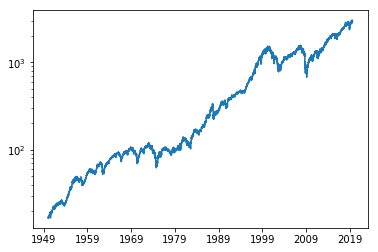

In [9]:
plt.plot(sp.Date, sp.Value);
plt.yscale('log');

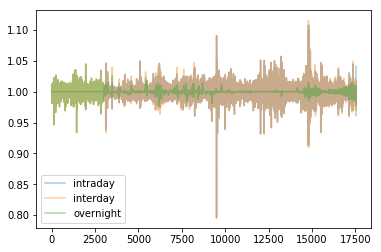

In [10]:
plt.plot(sp.ChangeSinceOpen, alpha=0.4, label='intraday')
plt.plot(sp.DailyChange, alpha=0.4, label='interday')
plt.plot(sp.OvernightChange, alpha=0.4, label='overnight')
plt.legend();

In [11]:
sp = sp.loc[3014:, :]
sp.index = range(sp.shape[0])

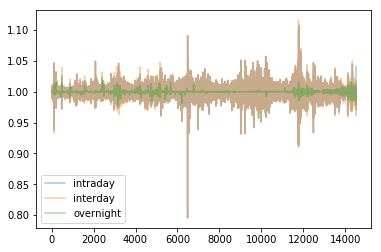

In [12]:
plt.plot(sp.ChangeSinceOpen, alpha=0.4, label='intraday')
plt.plot(sp.DailyChange, alpha=0.4, label='interday')
plt.plot(sp.OvernightChange, alpha=0.4, label='overnight')
plt.legend();

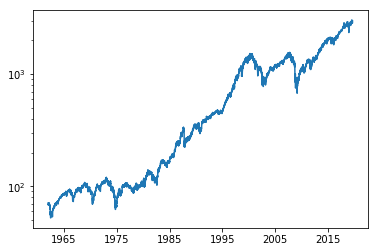

In [13]:
plt.plot(sp.Date, sp.Value);
plt.yscale('log');

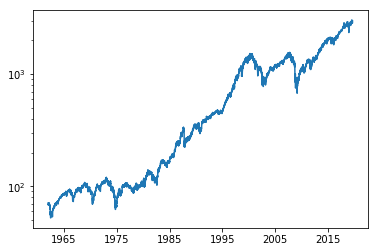

In [14]:
START_DATE = pd.to_datetime('1960-01-01')
sp = sp.loc[sp.Date >= START_DATE, :]
sp.index = range(sp.shape[0])
plt.plot(sp.Date, sp.Value)
plt.yscale('log');

In [15]:
def moving_dev_signals(x, params):
    '''
    @params
    x: list: time series of prices
    params: list: [up_qs, up_amounts, down_qs, down_amounts]
    up_qs, down_qs: lists: quantiles for which, moving upward/downward 
        across signals an action
    up_amounts, down_amounts: lists: amount to put in (+) or take out (-)
        associated with each up signal (qs)
    @return: array of signals (usually just one, but multiple events may
        occur on a single day)
    '''
    up_qs, up_amounts, down_qs, down_amounts = params
    x = x.tolist()
    n = len(x)
    up_qs = np.quantile(x, up_qs)
    down_qs = np.quantile(x, down_qs)
    signals = []
    for q, action in zip(up_qs, up_amounts):
        if x[n - 2] < q and x[n - 1] > q:
            signals.append(action)
    for q, action in zip(down_qs, down_amounts):
        if x[n - 2] > q and x[n - 1] < q:
            signals.append(action)
    return signals if signals else [0]

In [16]:
def sliding_window(x, window, func, **kwargs):
    '''
    Apply the function func to each frame of a timeseries, x with a moving
    window, window
    
    @params
    x: list: the complete time series of prices
    window: int: the number of days to apply the function to
    func: function: a function that takes a time series as input and 
        returns a list of one or more signals each day, where a signal is
        the percentage of money to put in or take out
    **kwargs: additional arguments to pass to func
    @return: a list of lists, each list in the primary list is a list of 
        signals for each single day
    '''
    n = len(x)
    all_signals = [[0] for _ in range(window)]
    for w in range(window, n):
        signals = func(x[(w - window):w], **kwargs)
        all_signals.append(signals)
    return all_signals

In [17]:
# Test 
x = sp.Value
up_qs = [0.05, 0.45]
up_amounts = [0.9, 0.3]
down_qs = [0.95, 0.55]
down_amounts = [-0.7, -0.9]
params = [up_qs, up_amounts, down_qs, down_amounts]
window = 30

In [18]:
def generate_actions(sp, window, func, params):
    x = sp.Value
    actions = sliding_window(x, window, func, params=params)
    actions = [0] + actions[:-1]
    sp['Actions'] = actions
    return sp

In [19]:
init_amount = sp.Value[0]
init_amount

71.129997

In [20]:
sp['Reserve'] = np.nan
sp['Invested'] = np.nan
sp.loc[0, 'Reserve'] = init_amount
sp.loc[0, 'Invested'] = 0.
sp.head()

,Date,Open,Close,Value,ChangeSinceOpen,DailyChange,OvernightChange,Reserve,Invested
0,1962-01-03,70.959999,71.129997,71.129997,1.002396,1.002396,1.0,71.129997,0.0
1,1962-01-04,71.129997,70.639999,70.639999,0.993111,0.993111,1.0,NaN,NaN
2,1962-01-05,70.639999,69.660004,69.660004,0.986127,0.986127,1.0,NaN,NaN
3,1962-01-08,69.660004,69.120003,69.120003,0.992248,0.992248,1.0,NaN,NaN
4,1962-01-09,69.120003,69.150002,69.150002,1.000434,1.000434,1.0,NaN,NaN


In [21]:
def update_values(row):
    reserve = row['Reserve']
    invested = row['Invested']
    change_since_open = row['ChangeSinceOpen']
    overnight_change = row['OvernightChange']
    invested *= overnight_change
    money_per_action = 0
    for action in row['Actions']:
        if action > 0: # Buy
            money_per_action = reserve * action
        if action < 0: # Sell
            money_per_action = invested * action    
    reserve -= money_per_action   # indent? 
    invested += money_per_action  # indent?
    invested *= change_since_open
    return reserve, invested

In [22]:
def predict_performance(sp):
    for day in range(1, sp.shape[0]):
        sp.loc[day, ['Reserve', 'Invested']] = sp.loc[
            day - 1, ['Reserve', 'Invested']]
        sp.loc[day, ['Reserve', 'Invested']] = update_values(
            sp.loc[day, :])
        sp['Total'] = sp['Reserve'] + sp['Invested']
    return sp

In [23]:
def print_params(params, window):
    for param in params:
        print('    [', end='')
        for p in param:
            print(f'{float(p):7.4}, ', end=' ')
        print('],')
    print('  window:', window)

# Repeat Search from Here

### 3-Deviations per direction (private portfolio)

In [54]:
def init_values(sd, init_window, init_params, min_window=10):
    up_qs, up_amts, down_qs, down_amts = init_params
    def trunc_normal(mean, sd, minval, maxval):
        val = np.random.normal(mean, scale=sd)
        val = max(min(val, maxval), minval)
        return val
    
    window = int(round(trunc_normal(init_window, 400*sd, min_window, 750)))
    up_q1   = trunc_normal(up_qs[0], sd, 0.05, 0.95)
    up_q2   = trunc_normal(up_qs[1], sd, 0.05, 0.95)
    up_q3   = trunc_normal(up_qs[2], sd, 0.05, 0.95)
    down_q1 = trunc_normal(down_qs[0], sd, 0.05, 0.95)
    down_q2 = trunc_normal(down_qs[1], sd, 0.05, 0.95)
    down_q3 = trunc_normal(down_qs[2], sd, 0.05, 0.95)
    up_amount1   = trunc_normal(up_amts[0], 2*sd, -0.99, 0.99)
    up_amount2   = trunc_normal(up_amts[1], 2*sd, -0.99, 0.99)
    up_amount3   = trunc_normal(up_amts[2], 2*sd, -0.99, 0.99)
    down_amount1 = trunc_normal(down_amts[0], 2*sd, -0.99, 0.99)
    down_amount2 = trunc_normal(down_amts[1], 2*sd, -0.99, 0.99)
    down_amount3 = trunc_normal(down_amts[2], 2*sd, -0.99, 0.99)
    up_qs = [up_q1, up_q2, up_q3]
    down_qs = [down_q1, down_q2, down_q3]
    up_amounts = [up_amount1, up_amount2, up_amount3]
    down_amounts = [down_amount1, down_amount2, down_amount3]
    params = [up_qs, up_amounts, down_qs, down_amounts]
    return window, params

```
32: Final value: $ 10048.22 (window = 194; sd = 0.002)
New best model!
    [ 0.5336,   0.2522,   0.6595,  ],
    [ 0.9476,    -0.99,   0.8988,  ],
    [ 0.3149,   0.8169,   0.6126,  ],
    [   0.99,   0.9753,  -0.02336,  ]]
  window: 194
  ```

In [55]:
BEST_EVER = 10048.22
# [up_qs, up_amts, down_qs, down_amts]
BEST_PARAMS = [
    [ 0.5336,   0.2522,   0.6595,  ],
    [ 0.9476,    -0.99,   0.8988,  ],
    [ 0.3149,   0.8169,   0.6126,  ],
    [   0.99,   0.9753,  -0.02336,  ]]
BEST_WINDOW = 194

In [56]:
DEFAULT_PARAMS = [
    [0.01, 0.5, 0.99],
    [1,   0,    0],
    [0.01, 0.5, 0.99],
    [0,   0,    -0.1]]

In [57]:
ITERS = 200
best_yet = 6708.39 # 10048.11
#best_params = DEFAULT_PARAMS
best_params = [
    [   0.05,   0.7992,     0.05,  ],
    [   0.99,     0.99,    -0.99,  ],
    [   0.95,     0.05,   0.3112,  ],
    [ 0.9415,     0.99,    0.734,  ]]
best_window = 193
print(f'best yet: {best_yet}\nbest params:\n{best_params}\n'
      f'best window: {best_window}')
sd = 0.434
best_data = None  # uncomment on first run

best yet: 6708.39
best params:
[[0.05, 0.7992, 0.05], [0.99, 0.99, -0.99], [0.95, 0.05, 0.3112], [0.9415, 0.99, 0.734]]
best window: 193


 1: Final value: $ 6708.38 (window = 193; sd = 0.434)
 2: Final value: $ 3162.97 (window = 72; sd = 0.430)
 3: Final value: $ 3222.36 (window = 141; sd = 0.425)
 4: Final value: $  667.41 (window = 203; sd = 0.421)
 5: Final value: $ 3118.61 (window = 199; sd = 0.417)
 6: Final value: $ 3731.06 (window = 323; sd = 0.413)
 7: Final value: $  881.99 (window = 10; sd = 0.409)
 8: Final value: $ 1777.08 (window = 59; sd = 0.405)
 9: Final value: $ 3960.16 (window = 202; sd = 0.400)
10: Final value: $ 3720.73 (window = 115; sd = 0.396)
11: Final value: $ 2216.98 (window = 172; sd = 0.393)
12: Final value: $ 3233.17 (window = 338; sd = 0.389)
13: Final value: $ 1313.11 (window = 65; sd = 0.385)
14: Final value: $ 6126.89 (window = 200; sd = 0.381)
15: Final value: $ 3525.66 (window = 130; sd = 0.377)
16: Final value: $ 1167.99 (window = 212; sd = 0.373)
17: Final value: $ 2415.06 (window = 388; sd = 0.370)
18: Final value: $  819.03 (window = 20; sd = 0.366)
19: Final value: $  864.65 (windo

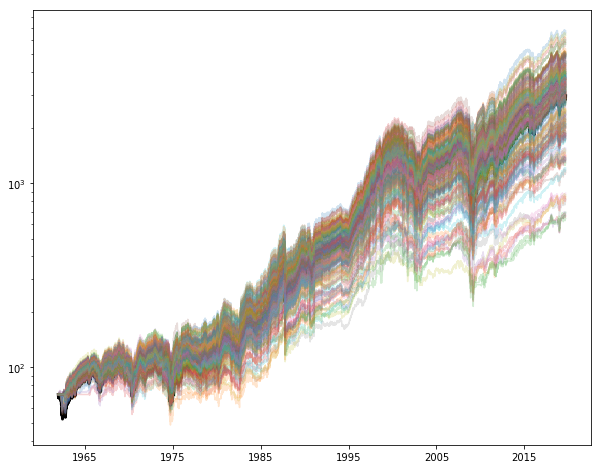

In [58]:
plt.figure(figsize=[10, 8])
plt.plot(sp.Date, sp.Value, 'k-', linewidth=3)
for i in range(ITERS):
    if i == 0:
        window = best_window
        params = best_params
    else:
        window, params = init_values(sd, best_window, best_params)
    sp = generate_actions(
        sp, window, func=moving_dev_signals, params=params)
    sp = predict_performance(sp)
    plt.plot(sp.Date, sp.Total, alpha=0.2);
    final_value = sp.Total.tolist()[-1]
    print(f'{i + 1:2d}: Final value: ${final_value:8.2f} '
          f'(window = {window}; sd = {sd:.3f})')
    if final_value > best_yet:
        print('New best model!')
        print_params(params, window)
        best_yet = final_value
        best_params = params
        best_window = window
        sd *= 1.5
        sd = min(sd, 1.024)
        best_data = sp.copy()
    else:
        sd *= 0.99
        sd = max(sd, 0.001)
        if best_data is None:
            best_data = sp.copy()
plt.yscale('log');    

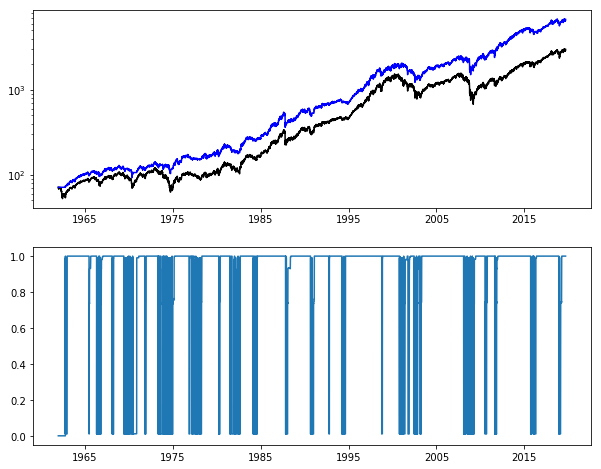

In [59]:
VIZ_START_DATE = pd.to_datetime('1960-01-01')
best_data['fraction_in'] = (best_data.Invested 
                            / (best_data.Invested + best_data.Reserve))
sub = best_data.loc[best_data.Date >= VIZ_START_DATE, :]
plt.figure(figsize=[10, 8])
plt.subplot(211)
plt.plot(sub.Date, sub.Value, 'k-')
plt.plot(sub.Date, sub.Total, 'b-')
plt.yscale('log')
plt.subplot(212)
plt.plot(sub.Date, sub.fraction_in);

In [60]:
percent_in_now = best_data.fraction_in.tolist()[-1]
percent_in_now

1.0

In [61]:
actions_taken = sub.Actions\
    .apply(lambda x: sum(x) != 0 if isinstance(x, list) else False)\
    .sum()
actions_taken

1302

### 2-Deviations per direction (401(k))

In [64]:
def init_values(sd, init_window, init_params, min_window=60):
    up_qs, up_amts, down_qs, down_amts = init_params
    def trunc_normal(mean, sd, minval, maxval):
        val = np.random.normal(mean, scale=sd)
        val = max(min(val, maxval), minval)
        return val
    
    window = int(round(trunc_normal(init_window, 400*sd, min_window, 750)))
    up_q1   = trunc_normal(up_qs[0], sd, 0.05, 0.95)
    up_q2   = trunc_normal(up_qs[1], sd, 0.05, 0.95)
    down_q1 = trunc_normal(down_qs[0], sd, 0.05, 0.95)
    down_q2 = trunc_normal(down_qs[1], sd, 0.05, 0.95)
    up_amount1   = trunc_normal(up_amts[0], 2*sd, -0.99, 0.99)
    up_amount2   = trunc_normal(up_amts[1], 2*sd, -0.99, 0.99)
    down_amount1 = trunc_normal(down_amts[0], 2*sd, -0.99, 0.99)
    down_amount2 = trunc_normal(down_amts[1], 2*sd, -0.99, 0.99)
    up_qs = [up_q1, up_q2]
    down_qs = [down_q1, down_q2]
    up_amounts = [up_amount1, up_amount2]
    down_amounts = [down_amount1, down_amount2]
    params = [up_qs, up_amounts, down_qs, down_amounts]
    return window, params

```
173: Final value: $ 8685.71 (window = 334; sd = 0.001)
New best model!
    [ 0.2165,   0.4202,  ],
    [-0.9088,   0.8857,  ],
    [ 0.9063,   0.3639,  ],
    [ 0.8707,   0.8904,  ],
  window: 334
  ```

In [65]:
BEST_YET =  8685.71
BEST_PARAMS = [
    [ 0.2165,   0.4202,  ],
    [-0.9088,   0.8857,  ],
    [ 0.9063,   0.3639,  ],
    [ 0.8707,   0.8904,  ]]
BEST_WINDOW = 334

In [66]:
DEFAULT_PARAMS = [
    [0.01, 0.5],
    [1,   0],
    [0.5, 0.99],
    [0, -0.1]]

In [67]:
ITERS = 200
best_yet = 6853.16
#best_params = DEFAULT_PARAMS
best_params = [
    [ 0.8031,   0.3218,  ],
    [ 0.9773,   0.9726,  ],
    [   0.95,   0.8998,  ],
    [-0.9791,     0.99,  ]]
best_window = 147
print(f'best yet: {best_yet}\nbest params:\n{best_params}\n'
      f'best window:{best_window}')
sd = 0.512
best_data = None # uncomment on first run

best yet: 6713.38
best params:
[[0.8074, 0.3078], [0.9771, 0.9761], [0.95, 0.9004], [-0.9319, 0.99]]
best window:147


 1: Final value: $ 6713.27 (window = 147; sd = 0.512)
 2: Final value: $  115.28 (window = 268; sd = 0.486)
 3: Final value: $ 4567.47 (window = 60; sd = 0.462)
 4: Final value: $  698.22 (window = 60; sd = 0.439)
 5: Final value: $ 3245.37 (window = 185; sd = 0.417)
 6: Final value: $ 3801.98 (window = 60; sd = 0.396)
 7: Final value: $ 2653.67 (window = 553; sd = 0.376)
 8: Final value: $ 2342.91 (window = 392; sd = 0.358)
 9: Final value: $ 3156.33 (window = 301; sd = 0.340)
10: Final value: $  518.48 (window = 246; sd = 0.323)
11: Final value: $ 3078.00 (window = 60; sd = 0.307)
12: Final value: $ 1130.53 (window = 115; sd = 0.291)
13: Final value: $ 1060.56 (window = 141; sd = 0.277)
14: Final value: $ 1189.18 (window = 133; sd = 0.263)
15: Final value: $ 3201.99 (window = 268; sd = 0.250)
16: Final value: $  430.14 (window = 140; sd = 0.237)
17: Final value: $  902.33 (window = 293; sd = 0.225)
18: Final value: $  530.08 (window = 261; sd = 0.214)
19: Final value: $ 3222.68 (wind

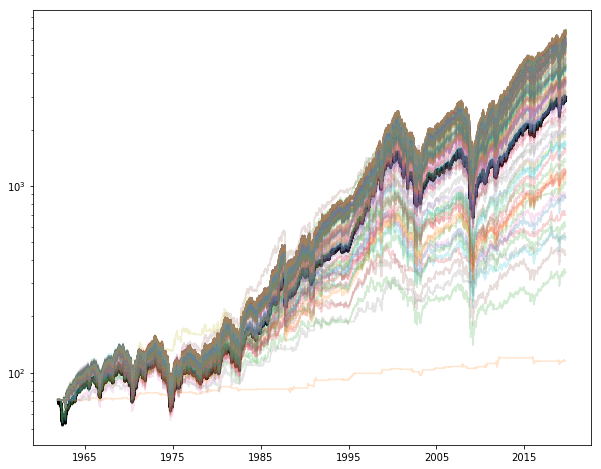

In [68]:
plt.figure(figsize=[10, 8])
plt.plot(sp.Date, sp.Value, 'k-', linewidth=3)
for i in range(ITERS):
    if i == 0:
        window = best_window
        params = best_params
    else:
        window, params = init_values(sd, best_window, best_params)
    sp = generate_actions(
        sp, window, func=moving_dev_signals, params=params)
    sp = predict_performance(sp)
    plt.plot(sp.Date, sp.Total, alpha=0.2);
    final_value = sp.Total.tolist()[-1]
    print(f'{i + 1:2d}: Final value: ${final_value:8.2f} '
          f'(window = {window}; sd = {sd:.3f})')
    if final_value > best_yet:
        print('New best model!')
        print_params(params, window)
        best_yet = final_value
        best_params = params
        best_window = window
        sd *= 1.5
        sd = min(sd, 1.024)
        best_data = sp.copy()
    else:
        sd *= 0.95
        sd = max(sd, 0.001)
        if best_data is None:
            best_data = sp.copy()
plt.yscale('log');    

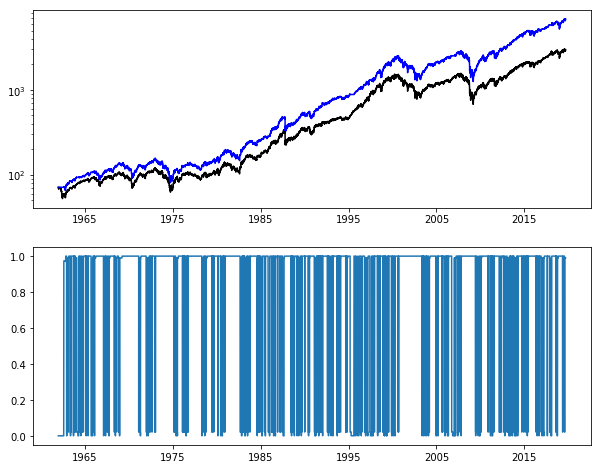

In [69]:
VIZ_START_DATE = pd.to_datetime('1960-01-01')
best_data['fraction_in'] = (best_data.Invested 
                            / (best_data.Invested + best_data.Reserve))
sub = best_data.loc[sp.Date >= VIZ_START_DATE, :]
plt.figure(figsize=[10, 8])
plt.subplot(211)
plt.plot(sub.Date, sub.Value, 'k-')
plt.plot(sub.Date, sub.Total, 'b-')
plt.yscale('log')
plt.subplot(212)
plt.plot(sub.Date, sub.fraction_in);

In [70]:
best_data.tail()

,Date,Open,Close,Value,ChangeSinceOpen,DailyChange,OvernightChange,Reserve,Invested,Actions,Total,fraction_in
14514,2019-08-30,2861.280029,2926.46,2926.46,1.022780,1.000643,0.978356,66.344504,6667.766599,[0],6734.111103,0.990148
14515,2019-09-03,2861.280029,2906.27,2906.27,1.015724,0.993101,0.977727,66.344504,6621.764874,[0],6688.109378,0.990080
14516,2019-09-04,2861.280029,2937.78,2937.78,1.026736,1.010842,0.984520,66.344504,6693.558552,[0],6759.903056,0.990186
14517,2019-09-05,2861.280029,2976.00,2976.00,1.040094,1.013010,0.973960,66.344504,6780.640569,[0],6846.985073,0.990310
14518,2019-09-06,2861.280029,2978.71,2978.71,1.041041,1.000911,0.961452,66.344504,6786.815144,[0],6853.159648,0.990319


In [71]:
best_data.fraction_in.tolist()[-1]

0.9903191363924675

In [72]:
actions_taken = sub.Actions\
    .apply(lambda x: sum(x) != 0 if isinstance(x, list) else False)\
    .sum()
actions_taken

1591

# 1-Deviation per Direction

In [73]:
def init_values(sd, init_window, init_params, min_window=30):
    up_qs, up_amts, down_qs, down_amts = init_params
    def trunc_normal(mean, sd, minval, maxval):
        val = np.random.normal(mean, scale=sd)
        val = max(min(val, maxval), minval)
        return val
    
    window = int(round(trunc_normal(init_window, 400*sd, min_window, 500)))
    up_q   = trunc_normal(up_qs[0], sd, 0.05, 0.95)
    down_q = trunc_normal(down_qs[0], sd, 0.05, 0.95)
    up_amount = trunc_normal(up_amts[0], 2*sd, -0.99, 0.99)
    down_amount = trunc_normal(down_amts[0], 2*sd, -0.99, 0.99)
    params = [[up_q], [up_amount], [down_q], [down_amount]]
    return window, params

```
197: Final value: $ 4992.51 (window = 325; sd = 0.001)
New best model!
    [ 0.1952,  ],
    [-0.3823,  ],
    [ 0.6841,  ],
    [   0.99,  ],
  window: 325
  ```        

In [74]:
BEST_YET = 4992.51
BEST_PARAMS = [
    [ 0.1952,  ],
    [-0.3823,  ],
    [ 0.6841,  ],
    [   0.99,  ]]
BEST_WINDOW = 325

In [75]:
DEFAULT_PARAMS = [[0.01], [1], [0.99], [-0.1]]

In [76]:
ITERS = 200
best_yet = 3959.82
#best_params = DEFAULT_PARAMS
best_params = [
    [ 0.3175,  ],
    [ 0.4305,  ],
    [0.05012,  ],
    [   0.99,  ]]
best_window = 60
print(f'best yet: {best_yet}\nbest params:\n{best_params}\n'
      f'best window:{best_window}')
sd = 0.512
best_data = None

best yet: 3959.82
best params:
[[0.3175], [0.4305], [0.05012], [0.99]]
best window:60


 1: Final value: $ 3120.82 (window = 60; sd = 0.512)
 2: Final value: $ 3808.54 (window = 196; sd = 0.486)
 3: Final value: $ 3026.38 (window = 30; sd = 0.462)
 4: Final value: $ 3018.94 (window = 30; sd = 0.439)
 5: Final value: $  798.85 (window = 30; sd = 0.417)
 6: Final value: $ 3743.70 (window = 89; sd = 0.396)
 7: Final value: $ 3017.08 (window = 30; sd = 0.376)
 8: Final value: $ 3654.26 (window = 143; sd = 0.358)
 9: Final value: $ 1753.09 (window = 258; sd = 0.340)
10: Final value: $ 3687.80 (window = 108; sd = 0.323)
11: Final value: $ 3510.81 (window = 91; sd = 0.307)
12: Final value: $ 3380.71 (window = 182; sd = 0.291)
13: Final value: $ 3074.79 (window = 47; sd = 0.277)
14: Final value: $ 3007.42 (window = 30; sd = 0.263)
15: Final value: $ 3314.28 (window = 91; sd = 0.250)
16: Final value: $  193.07 (window = 79; sd = 0.237)
17: Final value: $ 3718.15 (window = 106; sd = 0.225)
18: Final value: $ 3688.25 (window = 126; sd = 0.214)
19: Final value: $ 2066.59 (window = 55

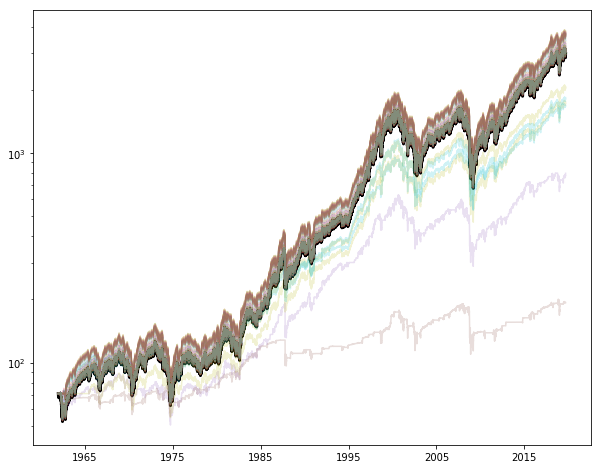

In [77]:
plt.figure(figsize=[10, 8])
plt.plot(sp.Date, sp.Value, 'k-', linewidth=3)
for i in range(ITERS):
    if i == 0:
        window = best_window
        params = best_params
    else:
        window, params = init_values(sd, best_window, best_params)
    sp = generate_actions(
        sp, window, func=moving_dev_signals, params=params)
    sp = predict_performance(sp)
    plt.plot(sp.Date, sp.Total, alpha=0.2);
    final_value = sp.Total.tolist()[-1]
    print(f'{i + 1:2d}: Final value: ${final_value:8.2f} '
          f'(window = {window}; sd = {sd:.3f})')
    if final_value > best_yet:
        print('New best model!')
        print_params(params, window)
        best_yet = final_value
        best_params = params
        best_window = window
        sd *= 1.5
        sd = min(sd, 1.024)
        best_data = sp.copy()
    else:
        sd *= 0.95
        sd = max(sd, 0.001)
        if best_data is None:
            best_data = sp.copy()
plt.yscale('log');    

In [78]:
best_data.tail()

,Date,Open,Close,Value,ChangeSinceOpen,DailyChange,OvernightChange,Reserve,Invested,Actions,Total
14514,2019-08-30,2861.280029,2926.46,2926.46,1.022780,1.000643,0.978356,0.0,3066.073640,[0],3066.073640
14515,2019-09-03,2861.280029,2906.27,2906.27,1.015724,0.993101,0.977727,0.0,3044.920428,[0.4305],3044.920428
14516,2019-09-04,2861.280029,2937.78,2937.78,1.026736,1.010842,0.984520,0.0,3077.933687,[0],3077.933687
14517,2019-09-05,2861.280029,2976.00,2976.00,1.040094,1.013010,0.973960,0.0,3117.977062,[0],3117.977062
14518,2019-09-06,2861.280029,2978.71,2978.71,1.041041,1.000911,0.961452,0.0,3120.816348,[0.4305],3120.816348


In [79]:
best_data.Actions.apply(lambda x: min(x) if isinstance(x, list) else x).min()

0.0

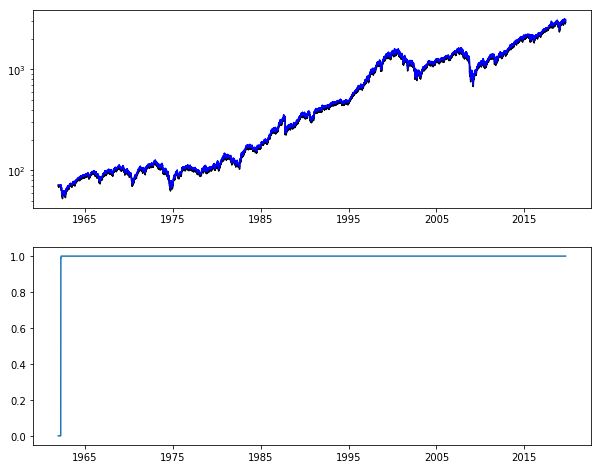

In [80]:
VIZ_START_DATE = pd.to_datetime('1960-01-01')
best_data['fraction_in'] = (best_data.Invested 
                            / (best_data.Invested + best_data.Reserve))
sub = best_data.loc[best_data.Date >= VIZ_START_DATE, :]
plt.figure(figsize=[10, 8])
plt.subplot(211)
plt.plot(sub.Date, sub.Value, 'k-')
plt.plot(sub.Date, sub.Total, 'b-')
plt.yscale('log')
plt.subplot(212)
plt.plot(sub.Date, sub.fraction_in);

In [81]:
sub.fraction_in.tolist()[-1]

1.0

In [82]:
actions_taken = sub.Actions\
    .apply(lambda x: sum(x) != 0 if isinstance(x, list) else False)\
    .sum()
actions_taken    

945